### Units Modulated by RPE? 

- Maybe look at one session first
- for each unit, split trials into 4 groups
  - strongly positive, weakly positive, weakly negative, strongly negative
- plot for each unit

### Imports/Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.behavioral_utils as behavioral_utils

import os
import pandas as pd
import matplotlib

SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"

### Load Behavioral Data

In [2]:
# Behavioral data
sess_name = "20180803"
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
valid_beh_rpes = behavioral_utils.get_rpes_per_session(sess_name, valid_beh)

### Tag trials into RPE groups
Calculate negative and positive medians

In [3]:
# find medians
neg_med = valid_beh_rpes[valid_beh_rpes.RPE_FE < 0].RPE_FE.median()
pos_med = valid_beh_rpes[valid_beh_rpes.RPE_FE > 0].RPE_FE.median()
print(f"Negative median {neg_med}")
print(f"Positive median {pos_med}")

Negative median -0.23530183353699086
Positive median 0.2700037023201789


In [4]:
# add median labels to 
def add_group(row):
    rpe = row.RPE_FE
    group = None
    if rpe < neg_med:
        group = "more neg"
    elif rpe >= neg_med and rpe < 0:
        group = "less neg"
    elif rpe >= 0 and rpe < pos_med:
        group = "less pos"
    elif rpe > pos_med:
        group = "more pos"
    row["group"] = group
    return row
valid_beh = valid_beh_rpes.apply(add_group, axis=1)

### Load Firing rates, Positions
probably look at smoothed versions

In [5]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "FeedbackOnset"
fr_path = f"/data/patrick_res/firing_rates/{sess_name}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
frs = pd.read_pickle(fr_path)
pos = spike_utils.get_unit_positions_per_sess(sess_name)
pos = spike_utils.get_manual_structure(pos)



### Plot RPE group firing rates by Unit

In [6]:
groups = ["more neg", "less neg", "less pos", "more pos"]
group_colors = {
    "more pos": "#024dfa",
    "less pos": "#86a8f7",
    "less neg": "#fa8c91",
    "more neg": "#fa000b",
}

def get_fr_np_array(fr_df):
    return fr_df.sort_values(by=["TrialNumber", "TimeBins"])["FiringRate"].to_numpy().reshape(
        len(fr_df.TrialNumber.unique()), 
        len(fr_df.TimeBins.unique())
    )

def plot_rpe_frs_per_unit(unit, frs, valid_beh, pos, ax):
    for group in groups:
        trials = valid_beh[valid_beh.group == group].TrialNumber
        group_frs = frs[(frs.TrialNumber.isin(trials)) & (frs.UnitID == unit)]
        vals = get_fr_np_array(group_frs)
        color = group_colors[group]
        visualization_utils.visualize_accuracy_across_time_bins(
            vals.T,
            1.3, 1.5, 0.1,
            ax,
            label=group,
            right_align=True, 
            sem=True,
            color=color
        )
        unit_pos = pos[pos.UnitID == unit].manual_structure.unique()[0]
    ax.set_title(f"Session {sess_name} Unit {unit} ({unit_pos})")
    ax.legend()
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Firing Rate (Hz)")


/tmp/ipykernel_1913301/1940627804.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 5))


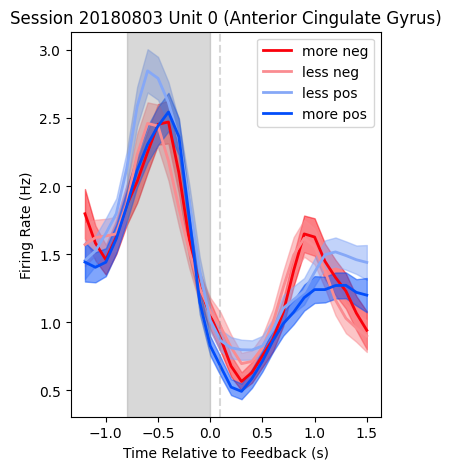

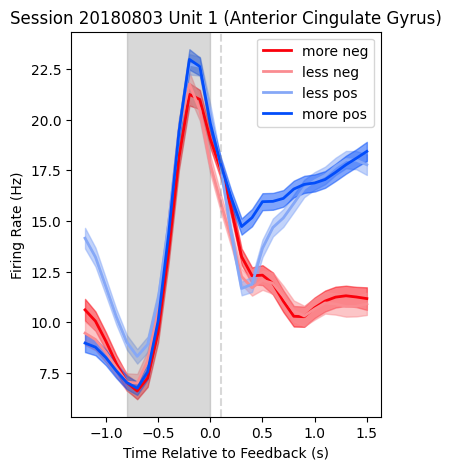

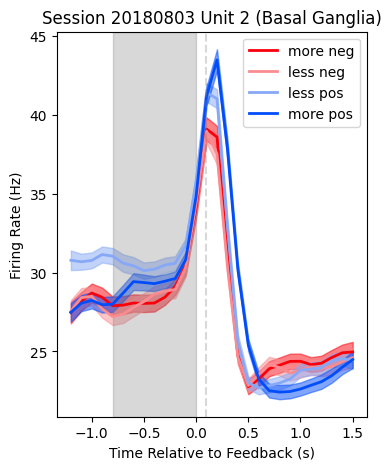

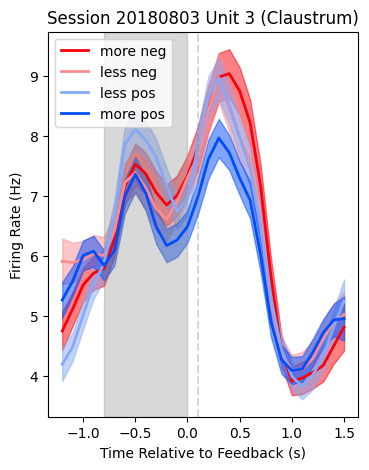

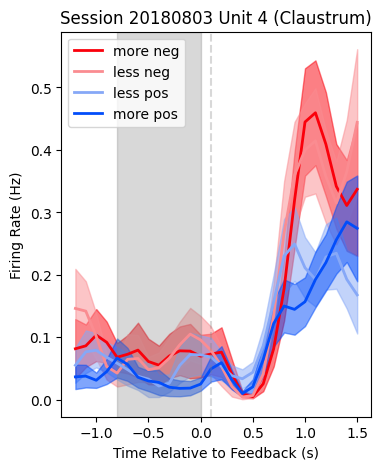

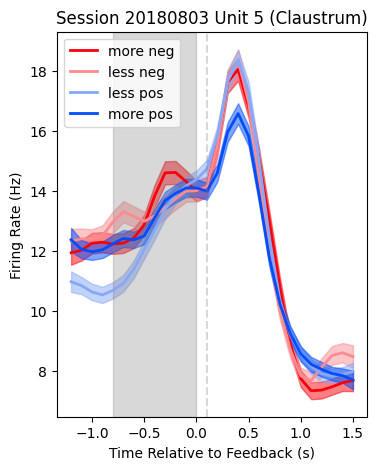

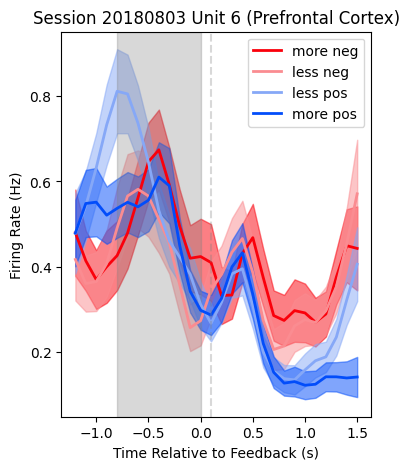

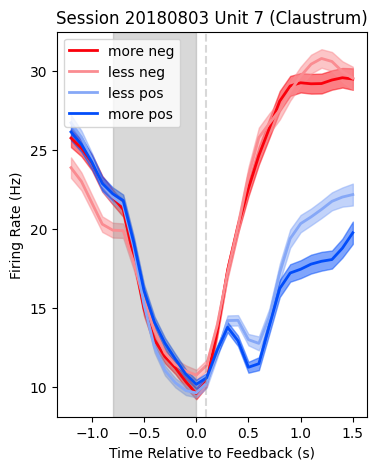

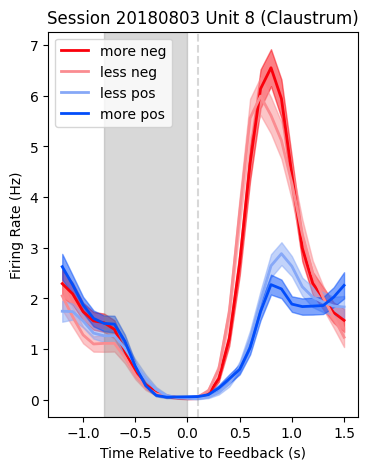

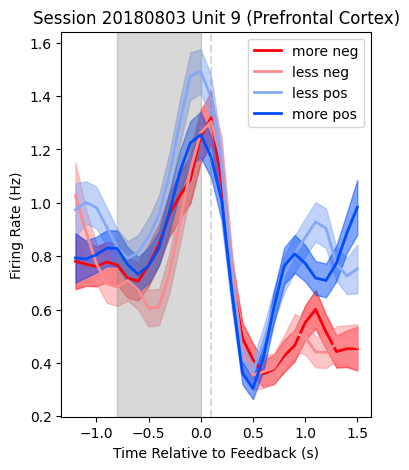

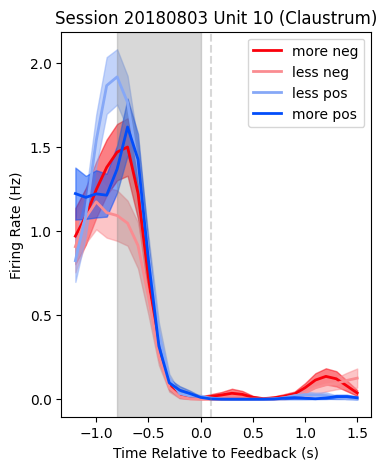

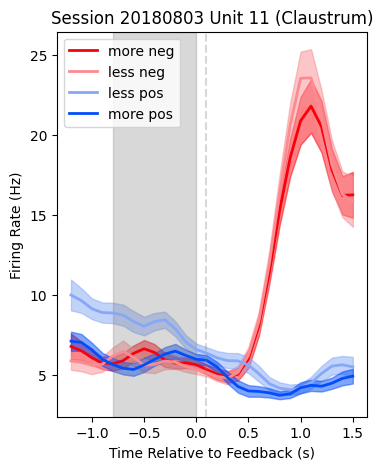

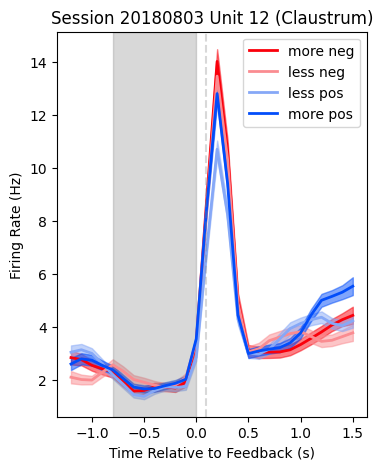

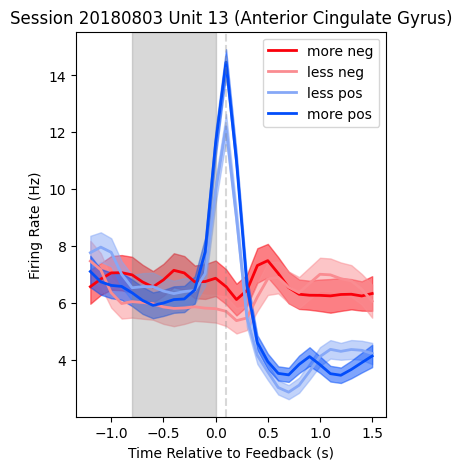

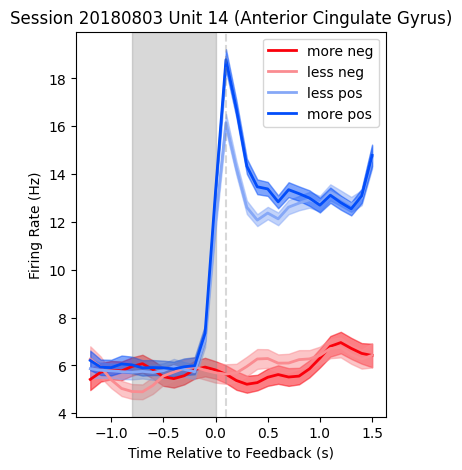

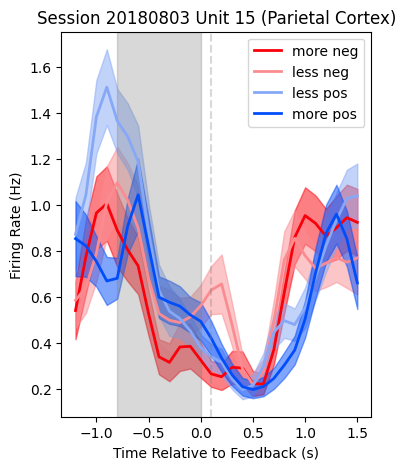

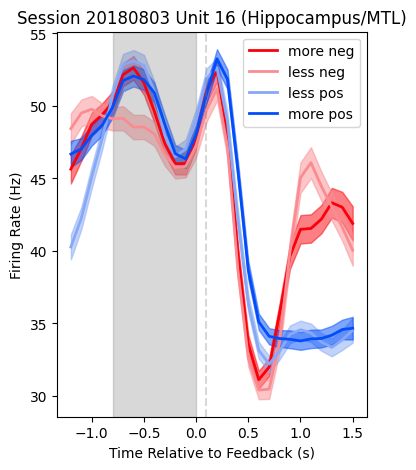

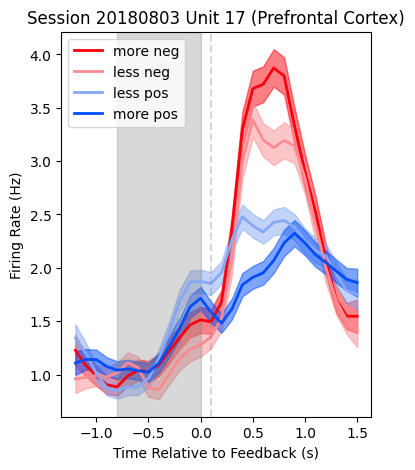

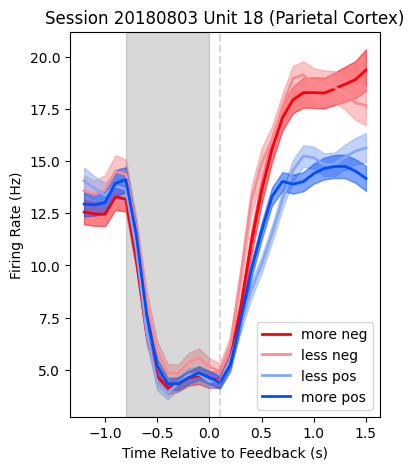

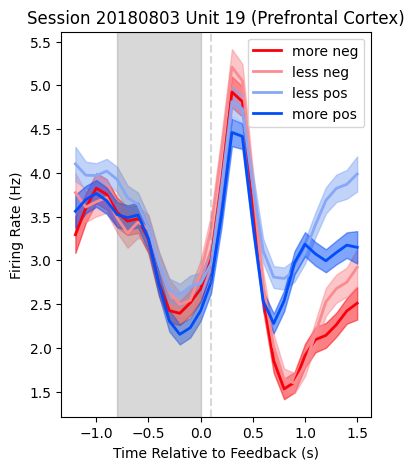

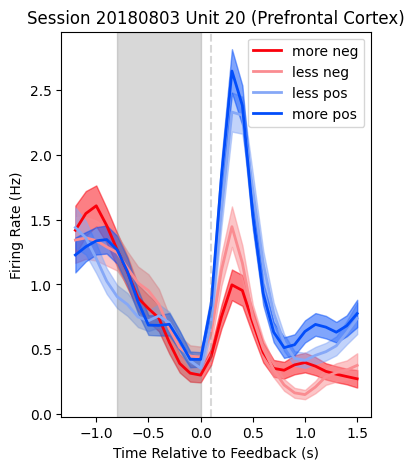

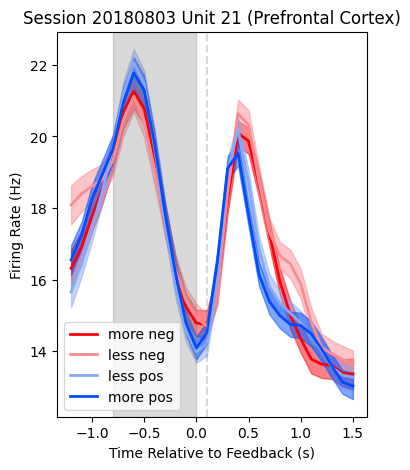

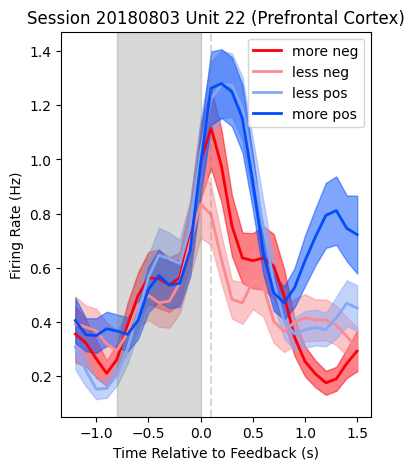

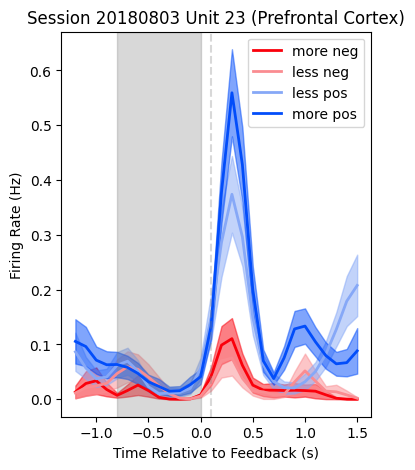

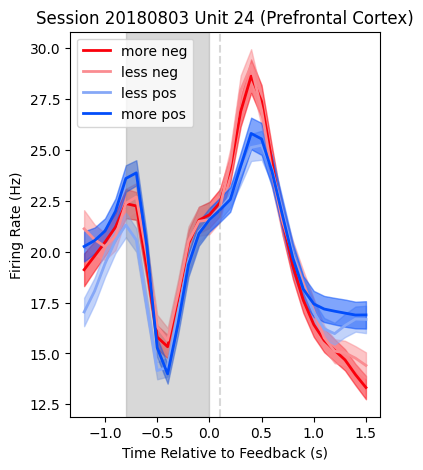

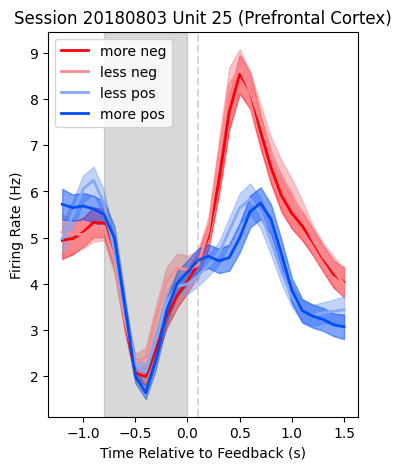

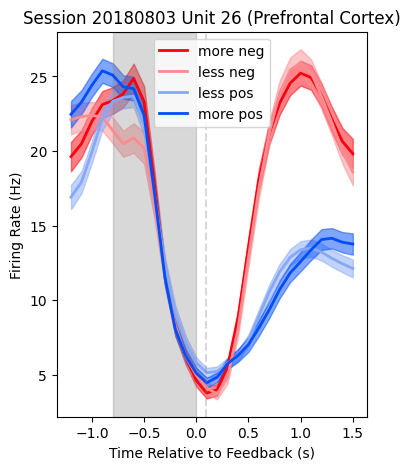

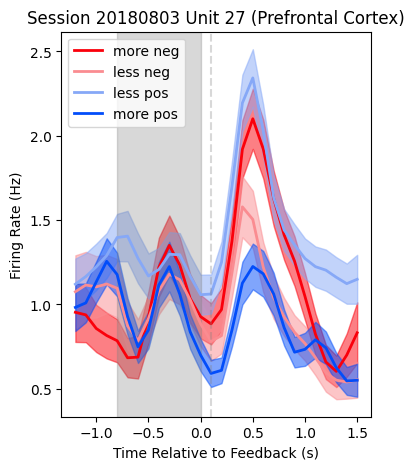

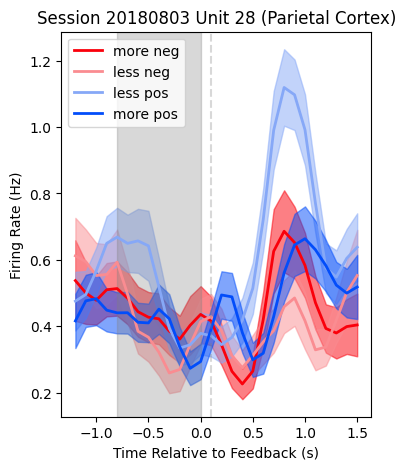

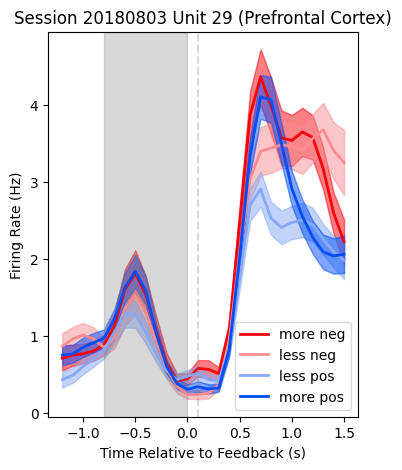

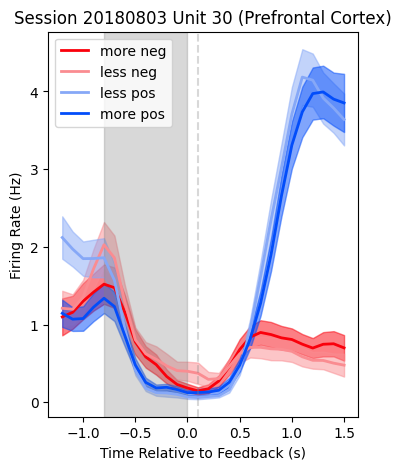

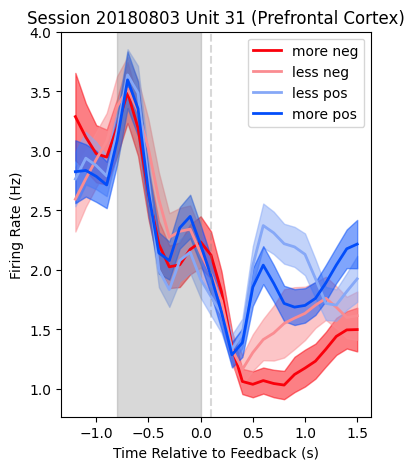

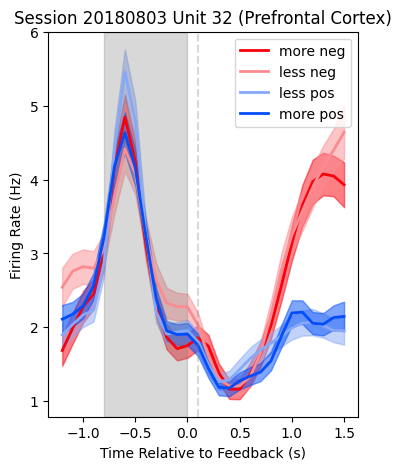

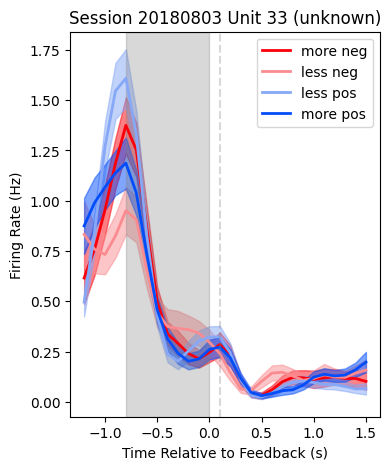

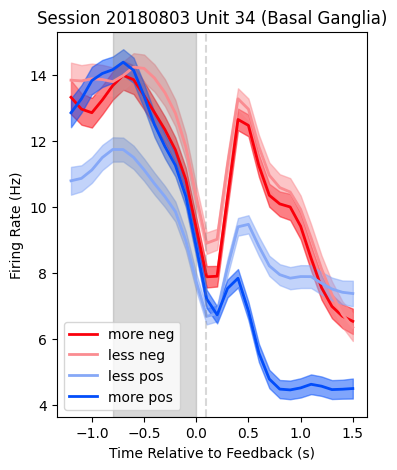

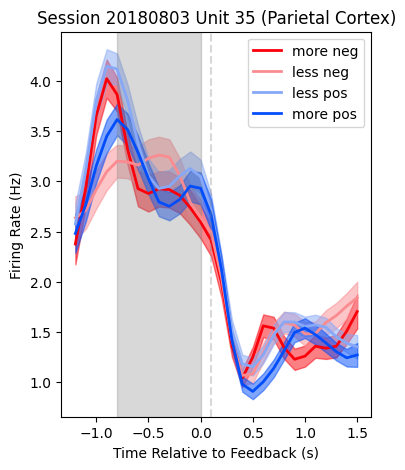

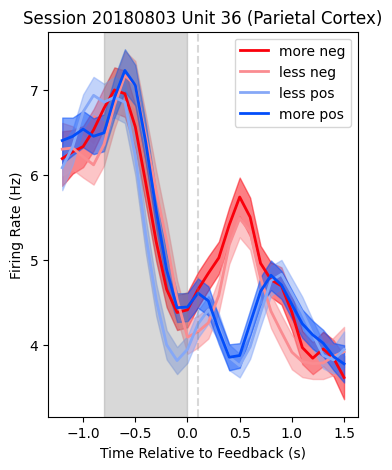

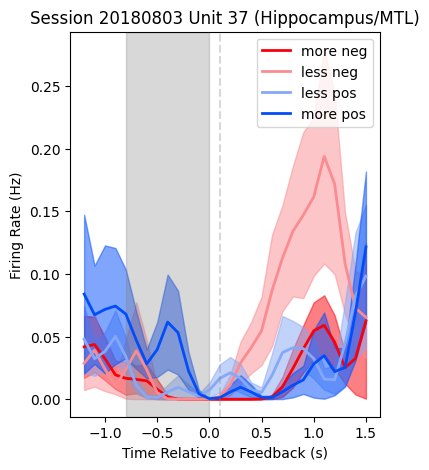

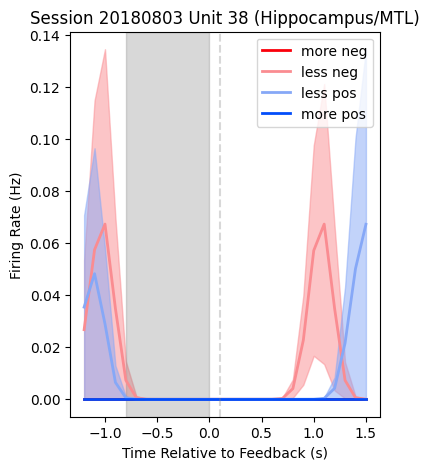

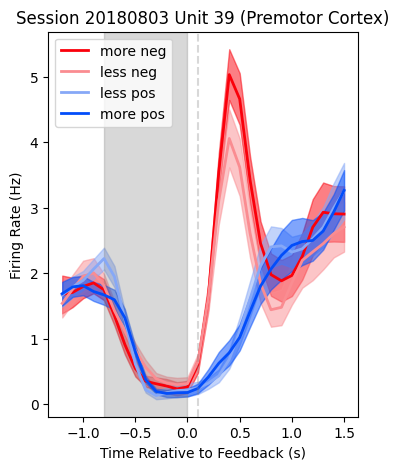

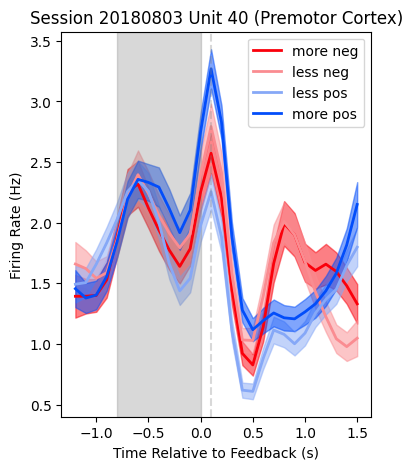

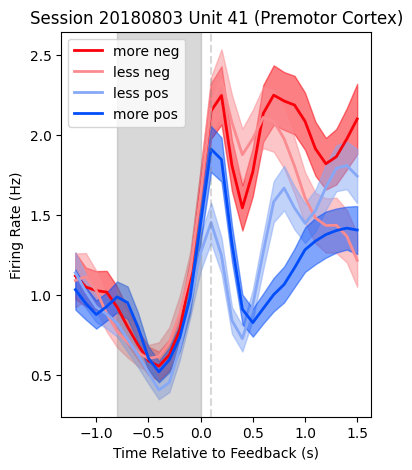

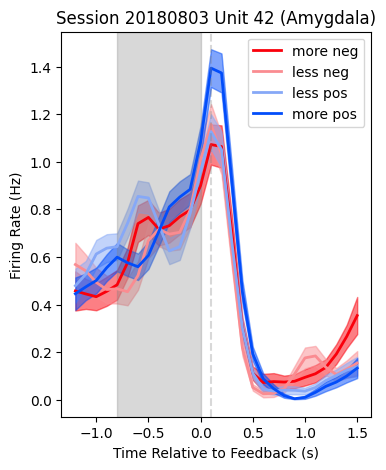

In [7]:
units = frs.UnitID.unique()
units.sort()
for unit in units:
    fig, ax = plt.subplots(figsize=(4, 5))
    plot_rpe_frs_per_unit(unit, frs, valid_beh, pos, ax)